**Librerias necesarias para implementar el aprendizaje supervisado**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
import random
import os

from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('ggplot')

### PARAMETROS DE CONFIGUARCION

In [3]:
#archivo que se va a leer para puntuar por cluster (carpeta ./recursos/)
archivoCSVLeido = 'conKMsVacio.csv'

#ponderaciones a la hora de puntuar el cluster
# mayor ponderacion = mayor importancia
ponderaciones = {
    'NumParadas': 0.2,
    'PorcentajePunto': 0.4,
    'Retraso': 0.8,
    'KmVacio': 0.6
}
n_clusters = 100
#archivo que se va a generar en formato csv para el entrenamiento supervisado
archivoCSVGeneradoPuntuado = '100gruposCluster.csv'

### CARGAR LOS DATOS

    previamente se han debido generar el archivo conKMsVacio.csv

In [4]:
dataframe = pd.read_csv(r"./recursos/" + archivoCSVLeido)
dataframe.head()
#dataframe.describe()

,IDconductor,CodigoInternoParadaCarga,CodigoInternoParadaDescarga,NumParadas,PorcentajePunto,Retraso,KmVacio
0,Y4446672G,03,C115205,750,0.375333,31.541944,292
1,Y4446672G,03,C115205,750,0.375333,31.919444,23
2,46401708J,03,C115205,587,0.394714,32.299167,297
3,46401708J,03,C115205,587,0.394714,31.299167,291
4,52069433D,03,C115205,908,0.505234,-5.424722,67


### ESTADISTICAS DE DISTRIBUCION DE LOS DATOS

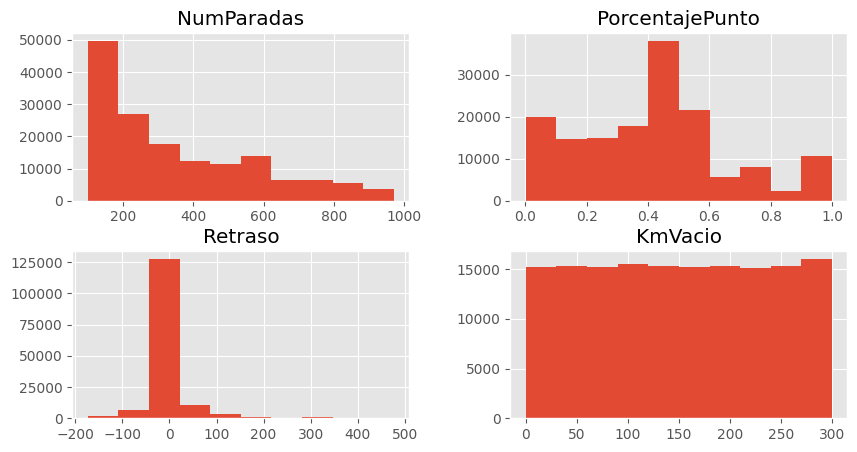

C:\Users\pablo.gallardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


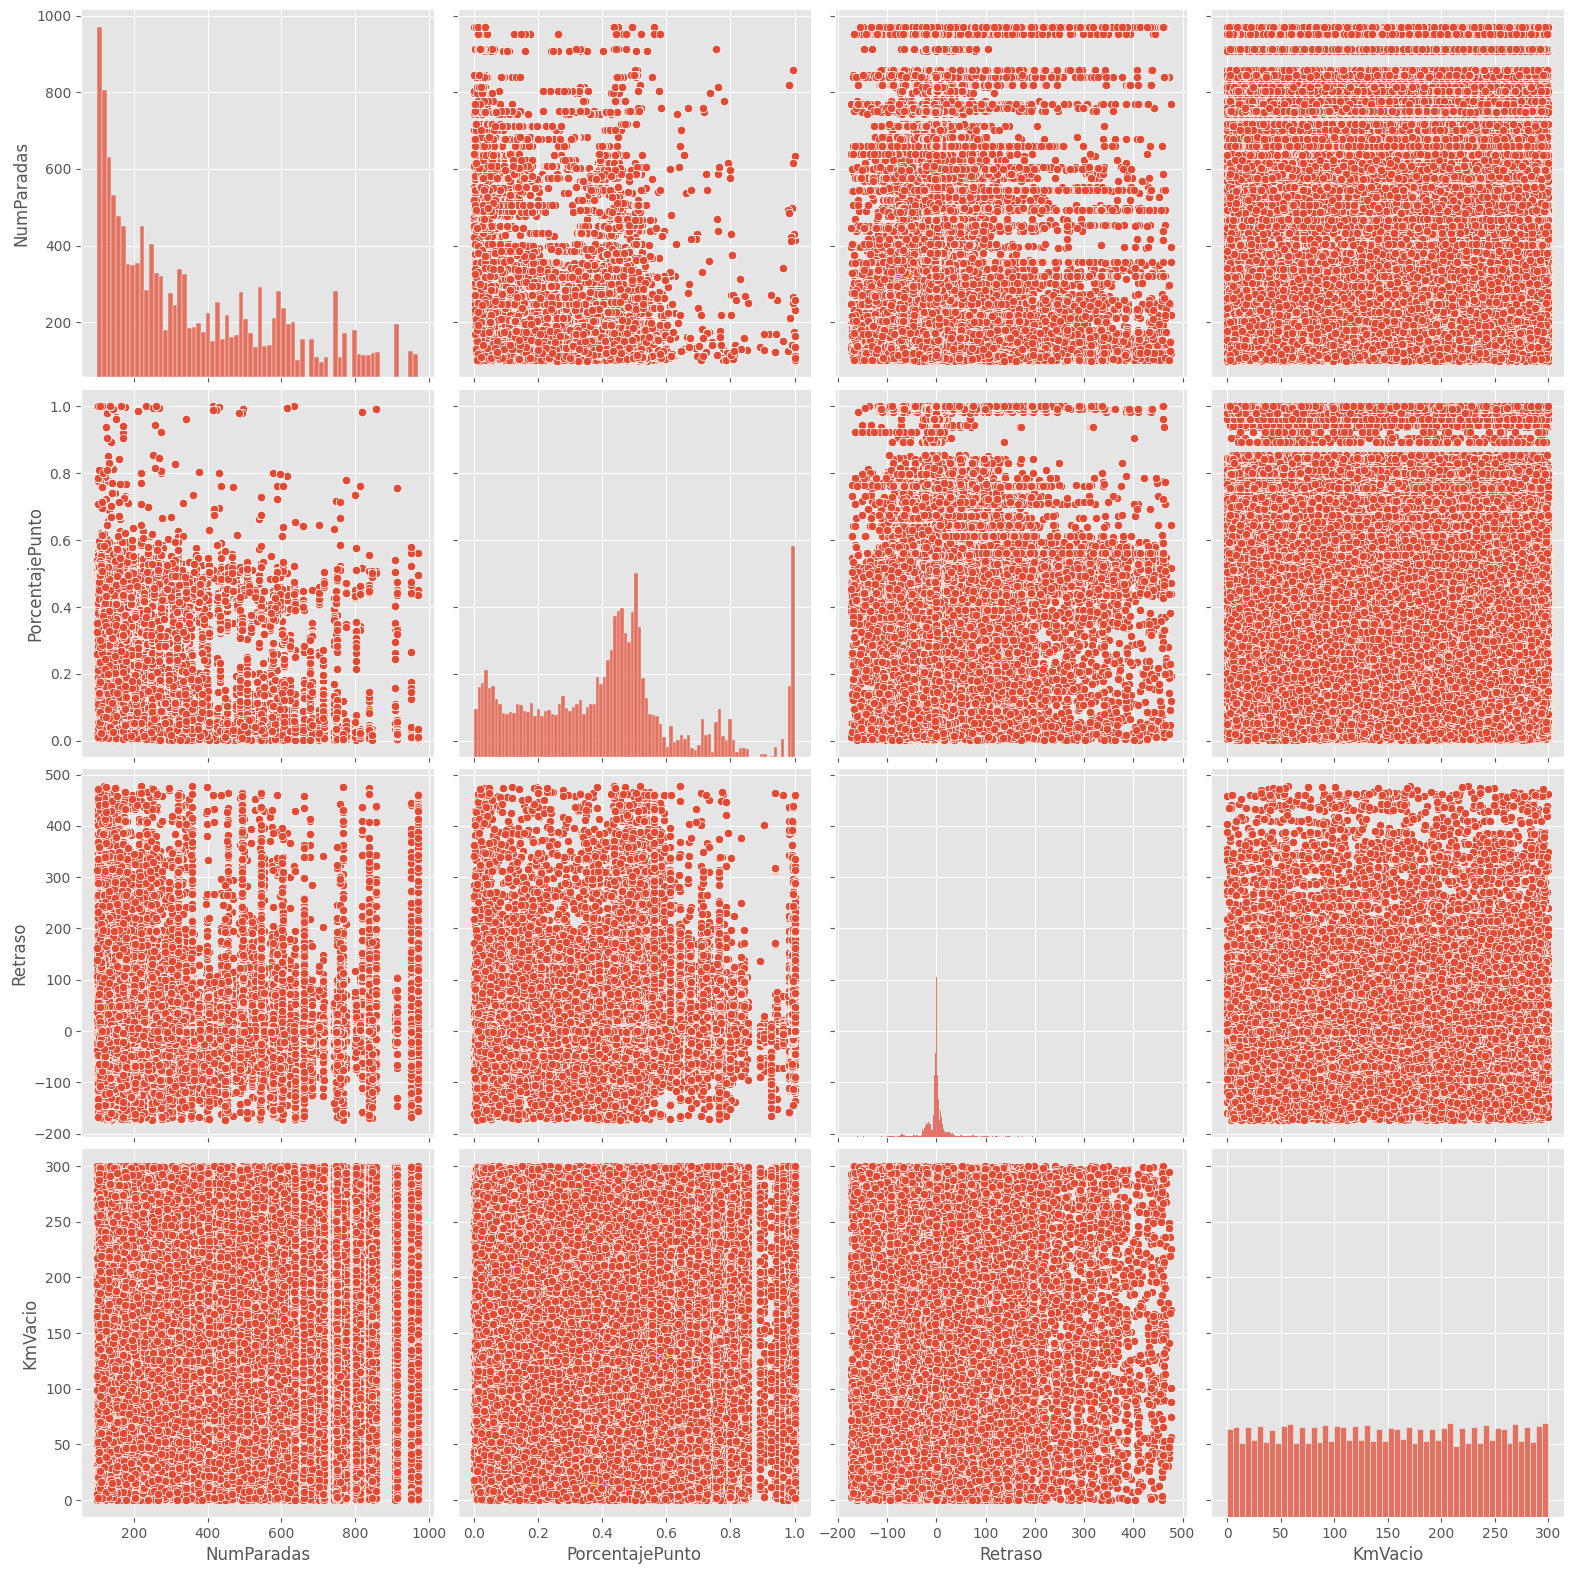

In [4]:
respuesta = input("Mostrar estadísticas de los datos (~1 min) (s/n): ")

if (respuesta == "s"):
    dataframe.drop(['IDconductor'], axis=1).hist()
    plt.show()
    sb.pairplot(dataframe.dropna(),size=4,vars=["NumParadas","PorcentajePunto","Retraso","KmVacio"],kind='scatter')

### ENTRENAMIENTO NO SUPERVISADO CLUSTER

#### ESCALAR LAS VARIABLES

In [5]:
scaler = StandardScaler()

X = scaler.fit_transform(
    dataframe.drop(['IDconductor', 'CodigoInternoParadaCarga', 'CodigoInternoParadaDescarga'], axis=1))
y = np.array(dataframe['IDconductor'])
X.shape

(153495, 4)

#### K-MEANS

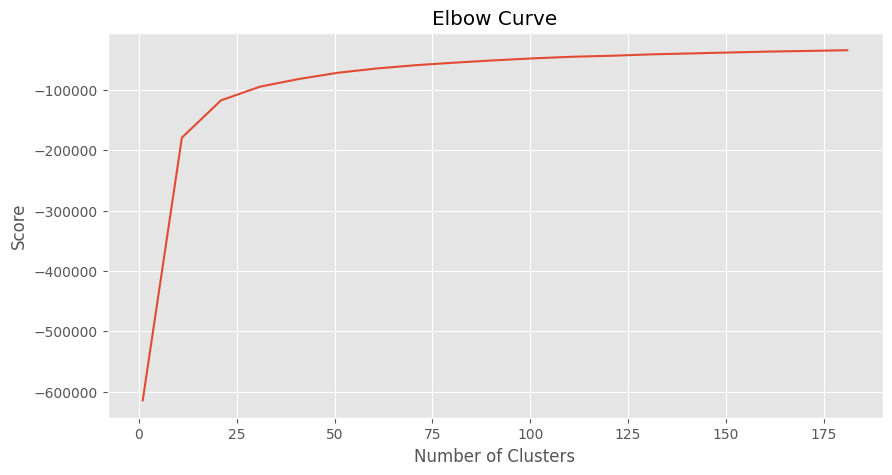

In [6]:
respuesta = input("Mostrar estadísticas de mejor numero de cluster (~3 min) (s/n): ")

if (respuesta == "s"):
    Nc = range(1, 182, 10)
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    kmeans
    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))] #codo de jambu
    score
    plt.plot(Nc,score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()

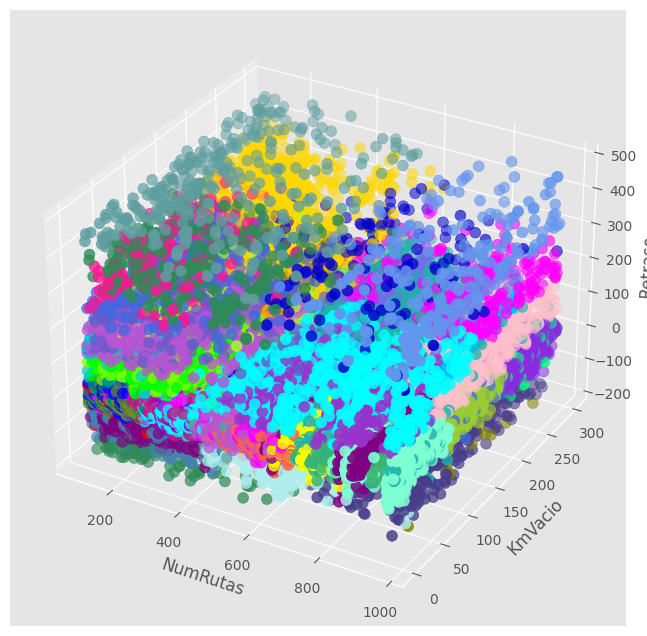

In [42]:
#calculo de loscentroides (en cada ejecucion pueden cambiar)
kmeans = KMeans(n_clusters=n_clusters, init='k-means++').fit(X)
centroids = kmeans.cluster_centers_
#print(centroids)

#Predict the clusters
labels = kmeans.predict(X)

# Getting the cluster centers
C = kmeans.cluster_centers_
# hasta 100
colores = [
    '#FF0000', '#FF4500', '#FFA500', '#FFD700', '#FFFF00',
    '#ADFF2F', '#32CD32', '#008000', '#006400', '#00FF00',
    '#7FFF00', '#00FF7F', '#2E8B57', '#3CB371', '#008080',
    '#20B2AA', '#00FFFF', '#00BFFF', '#1E90FF', '#4169E1',
    '#0000FF', '#0000CD', '#00008B', '#000080', '#8A2BE2',
    '#4B0082', '#8B008B', '#FF00FF', '#FF69B4', '#FF1493',
    '#C71585', '#FFC0CB', '#FFB6C1', '#FF69B4', '#FF1493',
    '#DB7093', '#ADFF2F', '#7FFF00', '#00FF00', '#32CD32',
    '#6B8E23', '#808000', '#556B2F', '#008000', '#9ACD32',
    '#8FBC8F', '#2E8B57', '#3CB371', '#00FFFF', '#AFEEEE',
    '#00CED1', '#20B2AA', '#5F9EA0', '#4682B4', '#6495ED',
    '#1E90FF', '#4169E1', '#0000FF', '#0000CD', '#00008B',
    '#483D8B', '#6A5ACD', '#7B68EE', '#8A2BE2', '#9400D3',
    '#8B008B', '#800080', '#BA55D3', '#FF00FF', '#FF69B4',
    '#FF1493', '#C71585', '#FFA07A', '#FF7F50', '#FF6347',
    '#FF4500', '#D2691E', '#FF8C00', '#FFA500', '#FFD700',
    '#ADFF2F', '#7FFF00', '#00FF00', '#00FA9A', '#20B2AA',
    '#7FFFD4', '#40E0D0', '#00FFFF', '#5F9EA0', '#4682B4',
    '#6495ED', '#0000FF', '#6A5ACD', '#7B68EE', '#8A2BE2',
    '#9400D3', '#9932CC', '#BA55D3', '#800080', '#FF00FF'
]
colores = colores[:n_clusters]

asignar=[]
for row in labels:
    asignar.append(colores[row])


#unscale
X_restored = scaler.inverse_transform(X)
dataframe_escaled = pd.DataFrame(X, columns=dataframe.columns.drop(['IDconductor', 'CodigoInternoParadaCarga', 'CodigoInternoParadaDescarga']))
C_unscaled = scaler.inverse_transform(C)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_restored[:, 0], X_restored[:, 3], X_restored[:, 2], c=asignar,s=60)
ax.scatter(C_unscaled[:, 0], C_unscaled[:, 3], C_unscaled[:, 2], marker='*', c=colores, s=100)
ax.set_xlabel('NumRutas')
ax.set_ylabel('KmVacio')
ax.set_zlabel('Retraso')
plt.show()

INFORMACION DE LOS CLUSTERES HECHOS (minimos, maximos, medias, medianas)

In [43]:
cluster_info = pd.DataFrame(columns=['Cluster', 'Feature', 'Min', 'Max', 'Mean', 'Median'])

#iterate over clusters
for cluster in range(n_clusters):
    cluster_subset = dataframe[labels == cluster]
    cluster_subset = cluster_subset.drop(['IDconductor', 'CodigoInternoParadaCarga', 'CodigoInternoParadaDescarga'], axis=1)
    
    for feature in cluster_subset.columns:
        feature_min = cluster_subset[feature].min()
        feature_max = cluster_subset[feature].max()
        feature_mean = cluster_subset[feature].mean()
        feature_median = cluster_subset[feature].median()
        new_row = pd.DataFrame({'Cluster': [cluster], 'Feature': [feature], 'Min': [feature_min], 'Max': [feature_max], 'Mean': [feature_mean], 'Median': [feature_median]})
        cluster_info = pd.concat([cluster_info, new_row], ignore_index=True)


cluster_info

C:\Users\pablo.gallardo\AppData\Local\Temp\ipykernel_23360\3620892032.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_info = pd.concat([cluster_info, new_row], ignore_index=True)


,Cluster,Feature,Min,Max,Mean,Median
0,0,NumParadas,100,272,173.639506,151.000000
1,0,PorcentajePunto,0.851562,1.0,0.982492,0.995968
2,0,Retraso,-121.069444,42.593889,-2.562379,0.363611
3,0,KmVacio,0,112,51.498765,51.000000
4,1,NumParadas,100,271,151.121243,140.000000
...,...,...,...,...,...,...
395,98,KmVacio,0,139,62.124521,62.000000
396,99,NumParadas,101,361,201.452949,178.000000
397,99,PorcentajePunto,0.611111,0.855422,0.754028,0.763689
398,99,Retraso,-67.951667,55.581944,0.239605,-0.163056


### CLASIFICAR LOS CLUSTER Y PUNTUARLOS

In [44]:
maxNumParadas = dataframe['NumParadas'].max()
minNumParadas = dataframe['NumParadas'].min()
maxRetraso = dataframe['Retraso'].max()
minRetraso = dataframe['Retraso'].min()
maxKmVacio = dataframe['KmVacio'].max()
minKmVacio = dataframe['KmVacio'].min()
def obtenScore(NumRutas, porcentajePunto, retraso, kmVacio):
    NumRutasScore = obtenScoreNumRutas(NumRutas)
    porcentajePuntoScore = obtenScorePorcentajePunto(porcentajePunto)
    retrasoScore = obtenScoreRetraso(retraso)
    kmVacioScore = obtenScoreKmVacio(kmVacio)
    # print(numParadasScore, porcentajePuntoScore, retrasoScore, kmVacioScore)
    scoreTotal = ponderaciones['NumParadas'] * NumRutasScore + ponderaciones['PorcentajePunto'] * porcentajePuntoScore - ponderaciones['Retraso'] * retrasoScore - ponderaciones['KmVacio'] * kmVacioScore # el score es entre [-0.6, 0.4]
    return scoreTotal
def obtenScoreNumRutas(NumRutas):
    return ((NumRutas - minNumParadas) /  (maxNumParadas - minNumParadas))*100
def obtenScorePorcentajePunto(porcentajePunto):
    return (porcentajePunto * 100)
def obtenScoreRetraso(retraso):
    return ((retraso - minRetraso) / (maxRetraso - minRetraso))*100
def obtenScoreKmVacio(kmVacio):
    return ((kmVacio - minKmVacio) / (maxKmVacio - minKmVacio))*100

scores = [] # guarda una tupla (nombre_cluster, puntuacion)
i = 0
for cluster in cluster_info.groupby('Cluster'):
    features = []
    for feature in range (0, 4):
        features.append(cluster[1].get('Mean').values[feature])
    # print(features)
    cluster_name = "Cluster" +str(i)
    scores.append((cluster_name, obtenScore(features[0], features[1], features[2], features[3])))
    i+=1

print(scores)

#guardará una lista con los cluster ordenados y puntuados de 100 a 0, descendiente, dependiendo del numero de clusters
ordenados = sorted(scores, key=lambda x: x[1], reverse=True) 
pasoPuntuacion = 100 / len(ordenados) * -1
# print(pasoPuntuacion)
for puntuacion, i in zip(range(100, 0, int(pasoPuntuacion)), range(0, len(ordenados))):
    fila = ordenados[i]
    nuevaFila = fila + (puntuacion,)
    ordenados[i] = nuevaFila

ordenados

[('Cluster0', 9.641152665647954), ('Cluster1', -26.796517922126032), ('Cluster2', -50.2989230826019), ('Cluster3', -88.19432656437588), ('Cluster4', 1.310806356406811), ('Cluster5', -32.80551986817547), ('Cluster6', -52.2859205459702), ('Cluster7', -42.82841746751274), ('Cluster8', -23.784472169439862), ('Cluster9', -21.803854471007718), ('Cluster10', -7.393226249870285), ('Cluster11', -52.7790821248616), ('Cluster12', 2.4667764280893802), ('Cluster13', -28.51436987555394), ('Cluster14', -14.516583508513339), ('Cluster15', -12.90372035816305), ('Cluster16', -3.2849174229498486), ('Cluster17', -9.770692775952817), ('Cluster18', -4.203888506920478), ('Cluster19', -50.97184005331093), ('Cluster20', -37.59131175301771), ('Cluster21', -73.57796114413517), ('Cluster22', -52.411979927180006), ('Cluster23', -65.97866085774913), ('Cluster24', -34.57703843301452), ('Cluster25', -35.89301174842987), ('Cluster26', -30.12578043648777), ('Cluster27', 8.444921076498362), ('Cluster28', -50.70328387569

[('Cluster98', 20.444999435147405, 100),
 ('Cluster52', 15.329572609244861, 99),
 ('Cluster47', 13.213072171024287, 98),
 ('Cluster0', 9.641152665647954, 97),
 ('Cluster27', 8.444921076498362, 96),
 ('Cluster60', 7.01776820829701, 95),
 ('Cluster85', 6.891691026515607, 94),
 ('Cluster12', 2.4667764280893802, 93),
 ('Cluster99', 1.7087400585168773, 92),
 ('Cluster4', 1.310806356406811, 91),
 ('Cluster49', 0.0725378923117237, 90),
 ('Cluster67', -0.18405211835343138, 89),
 ('Cluster66', -1.0696507656352523, 88),
 ('Cluster96', -2.122459756674626, 87),
 ('Cluster16', -3.2849174229498486, 86),
 ('Cluster18', -4.203888506920478, 85),
 ('Cluster40', -4.957736241192309, 84),
 ('Cluster50', -6.857973867236083, 83),
 ('Cluster10', -7.393226249870285, 82),
 ('Cluster17', -9.770692775952817, 81),
 ('Cluster94', -10.555568235009954, 80),
 ('Cluster91', -10.829476641091919, 79),
 ('Cluster58', -12.148775173982177, 78),
 ('Cluster74', -12.725063529978605, 77),
 ('Cluster44', -12.759164479396077, 76)

### CREAR CSV CON LAS ASIGNACIONES DE PUNTUACION

In [45]:
copy = pd.DataFrame()
# Copia las columnas IDConductor, CodigoInternoParadaCarga, etc.
copy = dataframe[['IDconductor', 'CodigoInternoParadaCarga', 'CodigoInternoParadaDescarga', 
                  'NumParadas', 'PorcentajePunto', 'Retraso', 'KmVacio']].copy()
copy['Cluster'] = labels

diccionario = {}
print(ordenados)
for fila in ordenados:
    numero_cluster = int(fila[0].replace('Cluster', ''))
    diccionario.setdefault(numero_cluster, fila[2])

diccionario

copy['Puntuacion'] = copy['Cluster'].map(diccionario)
copy


rutaArchivoGenerar = os.getcwd() + '/recursos/' + archivoCSVGeneradoPuntuado
print("Generando archivo " + rutaArchivoGenerar + " ...")
respuesta = input("¿Desea generar el archivo (y sobreescribir si existe)? (s/n): ")
if (respuesta == 's'):
    copy.to_csv(rutaArchivoGenerar, index=False)

[('Cluster98', 20.444999435147405, 100), ('Cluster52', 15.329572609244861, 99), ('Cluster47', 13.213072171024287, 98), ('Cluster0', 9.641152665647954, 97), ('Cluster27', 8.444921076498362, 96), ('Cluster60', 7.01776820829701, 95), ('Cluster85', 6.891691026515607, 94), ('Cluster12', 2.4667764280893802, 93), ('Cluster99', 1.7087400585168773, 92), ('Cluster4', 1.310806356406811, 91), ('Cluster49', 0.0725378923117237, 90), ('Cluster67', -0.18405211835343138, 89), ('Cluster66', -1.0696507656352523, 88), ('Cluster96', -2.122459756674626, 87), ('Cluster16', -3.2849174229498486, 86), ('Cluster18', -4.203888506920478, 85), ('Cluster40', -4.957736241192309, 84), ('Cluster50', -6.857973867236083, 83), ('Cluster10', -7.393226249870285, 82), ('Cluster17', -9.770692775952817, 81), ('Cluster94', -10.555568235009954, 80), ('Cluster91', -10.829476641091919, 79), ('Cluster58', -12.148775173982177, 78), ('Cluster74', -12.725063529978605, 77), ('Cluster44', -12.759164479396077, 76), ('Cluster15', -12.9037